In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Задание 1

#### 1. Реализовать генератор схемы Бернулли с заданной вероятностью успеха $p$. Построть на его основе датчик биномиального распределения.

In [2]:
def bern_rnd(p, out_size):
    if (p > 1 or p < 0):
        print('p =', p, 'is out of bounds [0, 1]')
        return
    return (np.random.random_sample(out_size) < p).astype(int)

In [3]:
def bin_rnd(n, p, out_size):
    if (p > 1 or p < 0):
        print('p =', p, 'is out of bounds [0, 1]')
        return
    if type(out_size) == int:
        return bern_rnd(p, (n, out_size)).sum(0)
    else:
        return bern_rnd(p, (n,) + out_size).sum(0)

Тест генератора распределения Бернулли с $p = 0.4$.

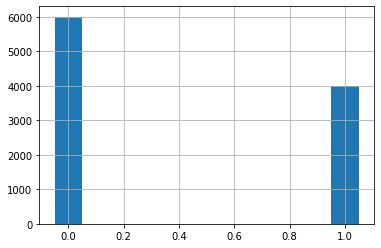

In [4]:
p = 0.4
plt.grid(True)
plt.hist(bern_rnd(p, 10000), bins = np.arange(-0.05, 1.15, 0.1))
plt.show()

Тест генератора биномиального распределения с $n = 10000, p = 0.5$.

In [5]:
from scipy.stats import norm

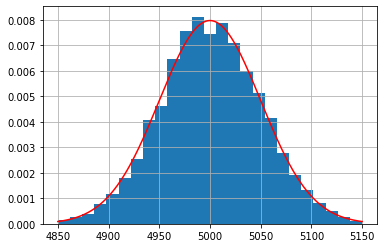

In [6]:
n = 10000
p = 0.5
plt.grid(True)
sigma = np.sqrt(n * p * (1 - p))
mu = n * p
plt.hist(bin_rnd(n, p, 10000), bins = 25, density = True, range=(mu - 3 * sigma, mu + 3 * sigma))
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
plt.plot(x, norm.pdf((x - mu) / sigma) / sigma, c='r')
plt.show()

#### 2. Реализовать генератор геометрического распределения. Проверить для него свойство отсутствия памяти.

Так как случайная величина $\lfloor \xi \rfloor$, где $\xi$ распределена экспоненциально с параметром $\lambda = -\ln(1 - p)$, имеет геометрическое распределение с параметром $p$, достаточно построить генератор экспоненциального распределения методом обращения функции распределения.

In [7]:
def exp_rnd(lam, out_size):
    return -np.log(np.random.random_sample(out_size)) / lam

In [8]:
def geom_rnd(p, out_size):
    if (p > 1 or p < 0):
        print('p =', p, 'is out of bounds [0, 1]')
        return
    return np.floor(exp_rnd(-np.log(1 - p), out_size))

Проверка отсутствия памяти. Случайные величины $\xi \sim \mathrm{Geom}(p)$ и $\eta = (\xi | \xi \geq \tau) - \tau$ должны иметь одинаковое распределение.

<function matplotlib.pyplot.show(*args, **kw)>

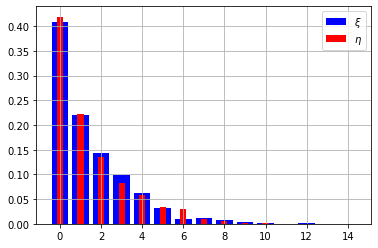

In [9]:
tau = 3
p = 0.4
samp_size = 1000
x = geom_rnd(p, samp_size)
y = geom_rnd(p, int(samp_size / ((1 - p) ** tau)))
y = y[y >= tau]
plt.grid(True)
bns = np.arange(-0.5, 15, 1)
plt.hist(x, bins=bns, rwidth = 0.8, density=True, color='b', label=r'$\xi$')
plt.hist(y - tau, bins=bns, rwidth=0.3, density=True, color='r', label=r'$\eta$')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

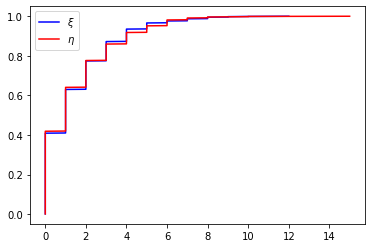

In [10]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf_xi = ECDF(x)
ecdf_eta = ECDF(y)
plt.plot(ecdf_xi.x, ecdf_xi.y, 'b', label=r'$\xi$')
plt.plot(ecdf_eta.x - tau, ecdf_eta.y, 'r', label=r'$\eta$')
plt.legend()
plt.show

#### 3. Рассмотреть игру в орлянку - бесконечную последовательность независимых испытаний с бросанием правильной монеты. Выигрыш $S_n$ определяется как сумма по $n$ испытаниям значений $1$ и $-1$ в зависимости от выпавшей стороны. Проиллюстрировать поведение $Y(i) = \dfrac{S_i}{\sqrt{n}}$ как функцию номера испытания $i = 1, \ldots, n$ для отдельно взятой траектории. Дать теоретическую оценку $Y(n)$ при $n \to \infty$

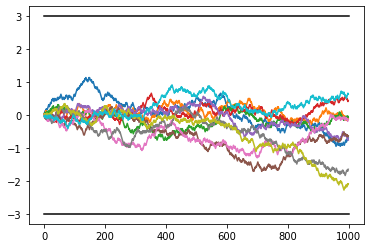

In [11]:
n = 1000
for i in range(0, 10):
    s_n = (2 * bern_rnd(0.5, n) - 1).cumsum()
    plt.plot(s_n / np.sqrt(n))
plt.plot([0, n], [3, 3], 'k', [0, n], [-3, -3], 'k')
plt.show()

При стремлении $n \to \infty$ распределение $Y(n)$ стремится к стандартному нормальному по ЦПТ.

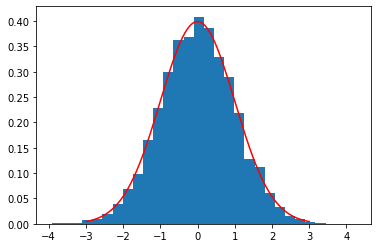

In [12]:
samp_size = 10000
n = 10000
sample = (2 * bern_rnd(0.5, (n, samp_size)) - 1).sum(0) / np.sqrt(n)
plt.hist(sample, bins=30, density=True)
x = np.linspace(-3, 3, 1000)
plt.plot(x, norm.pdf(x), c='r')
plt.show()

# Задание 2

#### 1. Построить датчик сингулярного распределения, имеющий в качестве функции распределения канторову лестницу. С помощью критерия Колмогорова убедиться в корректности работы датчика.

Для моделирования требуемого распределения воспользуемся тем, что носителем распределения является канторово множество, то есть числа, не имеющие единиц в троичной записи. Заметим также, что если $k$ разрядов случайной величины уже известны, то вероятности того, что $k+1$-й разряд равен $0$ и $2$ одинаковы. Это следует из самоподобия канторовой лестницы. Поэтому будем рассматривать схему Бернулли размера $n$ разрядов числа в троичной системе исчисления с таким n, чтобы ошибка в вычислении числа не превосходила $10^{10}$.

Так как ошибка равна
$ \sum_{k=n+1}^\infty23^{-k} = 3^{-n},$
достаточно взять $n \geq \log_3 10^{10} \approx 21$.

Итак, будем генерировать схему Бернулли с параметрами $n = 21, p = 0.5$, и, в случае успеха на $k$-м испытании будем считать, что $k$-й
разряд генерируемого числа равен 0, а в случае неудачи равен 2.

In [13]:
def cantor_rnd(out_size):
    acc = 21
    if type(out_size) == int:
        res = 2 * bern_rnd(0.5, (acc, out_size))
    else:
        res = 2 * bern_rnd(0.5, (acc,) + out_size)
    return (res * (np.ones(np.shape(res)) / 3).cumprod(0)).sum(0)

In [14]:
def cant_single(x):
    res = 0
    if x >= 1:
        res = 1
    elif x <= 0:
        res = 0
    else:
        i, k = 1, 0
        while i < 21 and k != 1:
            k = np.floor(3 * x)
            if k == 2:
                res += 1 / 2**i
            elif k == 1:
                res += 1 / 2**i
            i += 1
            x = (x - k / 3) * 3
    return res

In [15]:
def cantor_function(x): 
    if type(x) == int or type(x) == float:
        return cant_single(x)
    res = np.zeros(x.shape)
    for j in enumerate(x):
        res[j[0]] = cant_single(j[1])
    return res

Для проверки генератора воспользуемся критерием Колмогорова. Будем проверять гипотезу
$$H_0\colon \ F(\cdot) = F_0(\cdot),$$
где $F_0(\cdot)$ - функция Кантора. Для этого вычислим
$$D_n = \sup_x|F_n(x) - F_0(x)|,$$
где $F_n(\cdot)$ - эмпирическая функция распределения, построенная по выборке размера $n$. Положим $\gamma = K^{-1}(1-\alpha)$. Здесь $\alpha$ - уровень значимости, а $K^{-1}(x)$ - квантиль распределния Колмогорова порядка $x$. 

Будем отвергать гипотезу в случае, когда
$$\sqrt{n}D_n \geq \gamma.$$

Возьмем $\alpha = 0.05$. Тогда из таблицы распределения Колмогорова $\gamma = K^{-1}(0.95) = 1.36$.

<function matplotlib.pyplot.show(*args, **kw)>

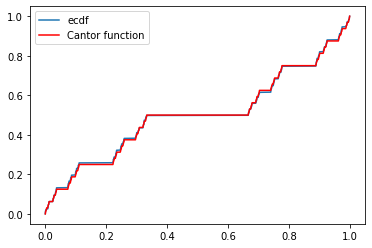

In [16]:
from statsmodels.distributions.empirical_distribution import ECDF

n = 1000
sample = cantor_rnd(n)
ecdf = ECDF(sample)
plt.plot(ecdf.x, ecdf.y, label='ecdf')

x = np.linspace(0, 1, n)
cant = cantor_function(x)
plt.plot(x, cant, label='Cantor function', c='r')

plt.legend()
plt.show

Проверка гипотезы

In [17]:
n = 1000
test_sz = 100
rejected = 0

x = np.linspace(0, 1, n)
cant = cantor_function(x)

for i in range(0, test_sz):
    sample = cantor_rnd(n)
    ecdf = ECDF(sample)
    D = np.max(np.abs(ecdf(x) - cantor_function(x)))
    gamma = 1.36
    is_rejected = D * np.sqrt(n) - gamma
    if is_rejected >= 0:
        rejected += 1
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 4.0 % tests.


#### 2. Для канторовых случайных величин проверить свойство симметричности относительно 0.5 и самоподобия относительно деления деления на 3 с помощью критерия Смирнова.

Пусть $X = (x_1, \ldots, x_n), Y = (y_1, \ldots, y_m)$ - выборки, элементы которых имеют функции распределения $F$ и $G$ соответственно, а $F_n, G_m$ - построенные по ним эмпирические функции распределения. Известно, что
$$\mathbb{P}\left(\sqrt{\frac{mn}{m+n}}D_{mn} < x\right) \to K(x).$$
Для проверки гипотезы
$$H_0\colon \ F(\cdot) = G(\cdot),$$
используется тест Смирнова: гипотеза отвергается, если 
$$\sqrt{\frac{mn}{m+n}}D_{mn} > \gamma, \quad \gamma = K^{-1}(1 - \alpha).$$

Как и в прошлом пункте, $\alpha = 0.05, \gamma = 1.36$.

Проверка симметричности.
$X$ - случайная величина с канторовой лестницей в качестве функции распределения. Проверим гипотезу
$$H_0\colon X \overset{d}{=} 1 - X.$$
с помощью критерия Смирнова.

In [18]:
n = 1000
test_sz = 1000
rejected = 0
x = np.linspace(0, 1, n)

for i in range(0, test_sz):
    samp1 = cantor_rnd(n)
    samp2 = 1 - cantor_rnd(n)
    ecdf1 = ECDF(samp1)
    ecdf2 = ECDF(samp2)
    D = np.max(np.abs(ecdf1(x) - ecdf2(x)))
    gamma = 1.36
    is_rejected = D * np.sqrt(n / 2) - gamma
    if is_rejected >= 0:
        rejected += 1
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 3.4 % tests.


Проверка самоподобия.
$$H_0\colon \dfrac{Y}{3} \overset{d}{=} \left(Y \, \bigg| \, Y \leq \dfrac13\right)$$

In [19]:
n = 1000
test_sz = 1000
rejected = 0
x = np.linspace(0, 1, n)

for i in range(0, test_sz):
    samp1 = cantor_rnd(n) / 3
    samp2 = cantor_rnd(2 * n)
    samp2 = samp2[samp2 <= 1 / 3]
    m = samp2.size
    ecdf1 = ECDF(samp1)
    ecdf2 = ECDF(samp2)
    D = np.max(np.abs(ecdf1(x) - ecdf2(x)))
    gamma = 1.36
    is_rejected = D * np.sqrt(m * n / (m + n)) - gamma
    if is_rejected >= 0:
        rejected += 1
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 3.7 % tests.


#### 3. Вычислить значение матожидания и дисперсии для данного распределения. Сравнить теоретические и эмпирические значения, проиллюстрировать сходимость.

В силу симметричности распределения относительно $0.5$, $\mathbb{E}X = 0.5$.
Условия симметричности и самоподобия можно переписать в виде
$$F(x) = 1 - F(1 - x), \quad F\left(\frac{x}{3}\right) = \frac12 F(x), \ x \in [0, \, 1].$$
Вычислим второй момент, пользуясь этими свойствами:
$$\mathbb{E}X^2 = \int_0^1x^2dF(x) = \int_0^{\frac13}x^2dF(x)+\int_\frac23^1 x^2dF(x)$$
После замен переменных, переводящих множество интегрирования в отрезок $[0,\, 1]$, используя свойства симметричности и самоподобия, получим
$$\mathbb{E}X^2 = \frac13 + \frac19\mathbb{E}X^2, \quad \mathbb{E}X^2 = \frac38,$$
откуда легко найти дисперсию $\mathrm{X} = \dfrac18.$

Оценим численно математическое ожидание, используя статистику $\overline{x} = \frac{1}{n}\sum_{k=1}^{n}x_k$, и дисперсию, используя статистику ${\hat \sigma}^2 = \frac{1}{n}\sum_{k=1}^{n}(x_k - \overline{x})^2.$

In [20]:
n = 1000
sample = cantor_rnd(n)
print('Estimation of mean:', sample.mean())
print('Estimation of variance:', sample.var())

Estimation of mean: 0.4866049423755773
Estimation of variance: 0.1257854545039594


<function matplotlib.pyplot.show(*args, **kw)>

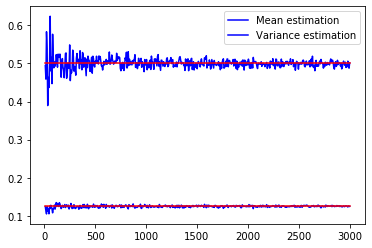

In [21]:
sz = 500
ns = np.linspace(10, 3000, sz)
means = np.zeros(sz)
varss = np.zeros(sz)
for i in range(0, sz):
    sample = cantor_rnd(int(ns[i]))
    means[i] = sample.mean()
    varss[i] = sample.var()
plt.plot(ns, means, c='b', label='Mean estimation')
plt.plot(ns, varss, c='b', label='Variance estimation')
plt.plot(ns, 0.5 * np.ones(sz), 'r', ns, 0.125 * np.ones(sz), 'r')
plt.legend()
plt.show

In [22]:
int(2.5)

2

# Задание 3

#### 1. Построить датчик экспоненциального распределения. Проверить для данного распределения свойство отсутствия памяти. Пусть $X_1, \ldots, X_n$ независимы и имеют экспоненциальное распределение с параметрами $\lambda_1, \ldots, \lambda_n$. Найти распределение случайной величины $Y = \min(X_1, \ldots, X_n)$.

Датчик экспоненциального распределения exp_rnd был построен методом обращения функции распределения в задании 1.2.

Отсутствие памяти.

<function matplotlib.pyplot.show(*args, **kw)>

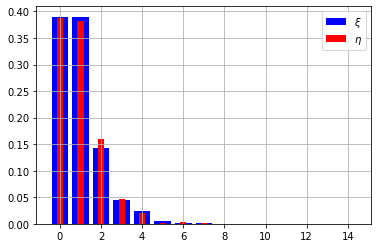

In [23]:
tau = 3
lam = 1
samp_size = 1000
x = exp_rnd(lam, samp_size)
y = exp_rnd(lam, int(samp_size * (np.exp(lam * tau))))
y = y[y >= tau]
plt.grid(True)
bns = np.arange(-0.5, 15, 1)
plt.hist(x, bins=bns, rwidth = 0.8, density=True, color='b', label=r'$\xi$')
plt.hist(y - tau, bins=bns, rwidth=0.3, density=True, color='r', label=r'$\eta$')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

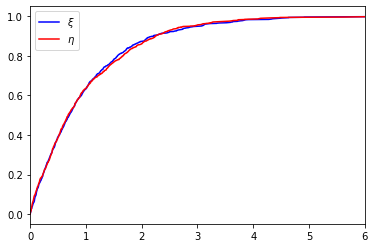

In [24]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf_xi = ECDF(x)
ecdf_eta = ECDF(y)
plt.plot(ecdf_xi.x, ecdf_xi.y, 'b', label=r'$\xi$')
plt.plot(ecdf_eta.x - tau, ecdf_eta.y, 'r', label=r'$\eta$')
plt.xlim((0, 6))
plt.legend()
plt.show

Найдем распределение $Y$:
$$F_Y(x) = \mathbb{P}(\min(X_1, \ldots, X_n) < x) = 1 - \mathbb{P}(X_1 \geq x, \ldots, X_n \geq x) = 1 - \prod_{k=1}^n(1- F_{X_k}(x)) = 1 - e^{-\sum \lambda_i x},$$
откуда $Y \sim \mathrm{exp}\left(\sum_{k=1}^n \lambda_k\right)$.

<function matplotlib.pyplot.show(*args, **kw)>

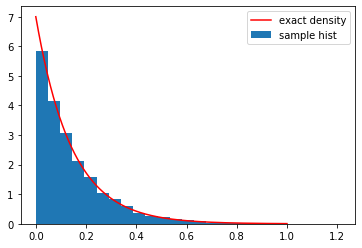

In [25]:
lam1 = 2
lam2 = 1
lam3 = 4
sz = 10000
samp = np.zeros((3, sz))
samp[0] = exp_rnd(lam1, sz)
samp[1] = exp_rnd(lam2, sz)
samp[2] = exp_rnd(lam3, sz)
samp = np.vstack((samp[0], samp[1], samp[2])).min(axis=0)
plt.hist(samp, bins=25, density=True, label = 'sample hist')
x = np.linspace(0, 1, 1000)
plt.plot(x, (lam1 + lam2 + lam3) * np.exp(-(lam1 + lam2 + lam3) * x), c='r', label='exact density')
plt.legend()
plt.show

#### 2. На основе датчика экспоненциального распределения построить датчик пуассоновского распределения.

Известно, что время между скачками пуассоновского процесса $X(t)$ с интенсивностью $\lambda$ имеет экспоненциальное распределение с параметром $\lambda$. При этом $X(1)$ имеет распределение Пуассона с параметром $\lambda$. Таким образом, при моделировании $\xi_k \sim \exp(\lambda)$ до тех пор, пока их сумма не достигнет 1
$$\sum_{k=1}^\eta \xi_k > 1,$$
величина $\eta - 1$ будет иметь требуемое пуассоновское распределение.

In [26]:
def pois_exp_single(lam):
    sum = 0
    res = -1
    while sum <= 1:
        sum += exp_rnd(lam, 1)
        res += 1
    return res

In [27]:
def pois_exp_rnd(lam, out_size):
    res = np.zeros(out_size)
    for i in range(0, out_size):
        res[i] = pois_exp_single(lam) 
    return res

<function matplotlib.pyplot.show(*args, **kw)>

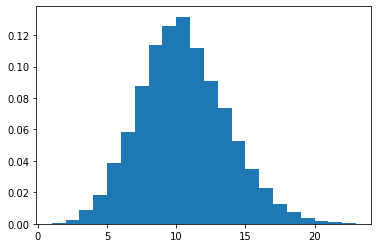

In [28]:
sample = pois_exp_rnd(10, 10000)
plt.hist(sample, density=True, bins=22)
plt.show

#### 3. Построить датчик пуассоновского распределения как предел биномиального. С помощью критерия хи-квадрат убедиться, что получен датчик распределения Пуассона.

По теореме Пуассона биномиальное распределение с малым $p$ и $n$ таким, что $np = \lambda$ будет приблизительно совпадать с пуассоновским распределением с параметром $\lambda$. Точнее, пусть $\nu_n \sim \mathrm{Bi}(n, \, p)$. Тогда верная следующая оценка
$$\left|\mathbb{P}(\nu_n \in A) - \sum_{k \in A}e^{-\lambda}\frac{\lambda^k}{k!}\right| \leq np^2 = \lambda p.$$

Потребуем, чтобы ошибка не превосходила $\varepsilon = 0.001$. Будем моделировать биномиальное распределение с параметрами $p = \frac{\varepsilon}{\lambda}, n = \frac{\lambda}{p}$.

In [29]:
def pois_bin_rnd(lam, out_sz):
    eps = 0.001
    p = eps / lam
    n = int(lam / p)
    return bin_rnd(n, p, out_sz)

Проверим построенный генератор при $\lambda = 4$ при помощи критерия хи-квадрат. Рассмотрим следующее расбиение множества целых неотрицательных чисел:
$$\Delta_1 = \{0, \ 1\}, \Delta_2 = \{2\}, \Delta_3 = \{3\}, \Delta_4 = \{4\}, \Delta_5 = \{5\}, \Delta_6 = \{6\}, \Delta_2 = \{k \geq 7\}.$$
Вычислим вероятности попадания в каждое множество:
$$p_i = \mathbb{P}(\Delta_i).$$

In [30]:
def pois_prob(lam, k):
    return np.exp(-lam) * lam**k / np.prod(range(1, k + 1))

In [31]:
lam = 4
p = np.zeros(7)
p[0] = pois_prob(lam, 0) + pois_prob(lam, 1)
p[1] = pois_prob(lam, 2)
p[2] = pois_prob(lam, 3)
p[3] = pois_prob(lam, 4)
p[4] = pois_prob(lam, 5)
p[5] = pois_prob(lam, 6)
p[6] = 1 - p[0:6].sum()
print(p)

[0.09157819 0.14652511 0.19536681 0.19536681 0.15629345 0.10419563
 0.11067398]


Для проверки гипотезы
$$H_0 \colon X \sim \mathrm{Pois}(\lambda)$$ с уровнем значимости $\alpha = 0.05$
будем использовать статистику
$$Q = \sum_{i = 1}^{7} \frac{(N_i - np_i)^2}{np_i},$$
где $N_i$ - число элементов выборки, попавший в $\Delta_i$, $n$ - размер выборки.

Будем отклонять гипотезу, если $Q \geq \gamma, \ \gamma = \chi_6^{-1}(1 - \alpha)$. $\chi_6^{-1}(x)$ - квантиль распределения хи-квадрат с 6 степенями свободы порядка $x$. 

In [32]:
from scipy.stats import chi2
alpha = 0.05
gamma = chi2.ppf(1 - alpha, 6)
print(gamma)

12.591587243743977


In [33]:
n = 500
test_sz = 100
rejected = 0

for i in range(0, test_sz):
    samp = pois_bin_rnd(lam, n)
    ns = np.zeros(7)
    ns[0] = (samp == 0).sum() + (samp == 1).sum()
    for j in range(1, 6):
        ns[j] = (samp == j + 1).sum()
    ns[6] = n - ns[0:6].sum()
    q = ((ns - n * p) ** 2 / (n * p)).sum()
    if q >= gamma:
        rejected += 1
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 4.0 % tests.


#### 4. Построить датчик стандартного нормального распределения методом моделирования случайных величин с переходом в полярные координаты. Проверить при помощи t-критерия Стьюдента равенство матожиданий, а при помощи критерия Фишера равенство дисперсий.

In [34]:
def norm_polar_rnd(mu, sigma, out_sz):
    size = np.prod(out_sz)
    n = int(np.ceil(size / 2))
    r = np.sqrt(exp_rnd(0.5, n))
    angle = 2 * np.pi * np.random.rand(n)
    res = np.concatenate([r * np.sin(angle), r * np.cos(angle)])
    return np.reshape(sigma * res[0:size] + mu, out_sz)

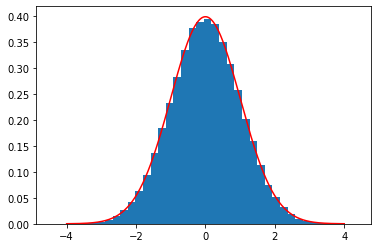

In [35]:
samp = norm_polar_rnd(0, 1, 100000)
plt.hist(samp, bins=40, density=True)
x = np.linspace(-4, 4, 1000)
plt.plot(x, norm.pdf(x), c='r')
plt.show()

Проверим правильность работы датчика для $\mu = 1, \sigma = 2$ с помощью t-теста Стьюдента. Для выборки размера $n$ вычислим статистики
$$\sigma' = \sqrt{\dfrac{1}{n-1}\sum_i(X_i - \bar X)^2},$$
$$U = \sqrt{n}\frac{\bar X - \mu}{\sigma'}.$$
Если элементы выборки имеют нормальное распределение с матожиданием $\mu$, то $U$ имеет распределение Стьюдента с $n - 1$ степенью свободы.

Положим уровень значимости $\alpha = 0.05$. Будем отклонять гипотезу
$$H_0\colon\ \mathbb{E}X = \mu,$$
когда $|U| \geq \gamma, \ \gamma = T_n^{-1}\left(1 - \frac{\alpha}{2}\right).$

In [36]:
from scipy.stats import t
alpha = 0.05
n = 1000
gamma = t.ppf(1 - alpha / 2, n - 1)
print(gamma)

1.9623414611334487


In [37]:
test_sz = 100
rejected = 0
mu = 1
sigma = 2

for i in range(0, test_sz):
    samp = norm_polar_rnd(mu, sigma, n)
    U = np.sqrt(n) * (samp.mean() - mu) / np.sqrt(samp.var() * n / (n - 1))
    if abs(U) >= gamma:
        rejected += 1
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 4.0 % tests.


Проверим равенство дисперсий нормального распределения с параметрами $\mu = 1, \sigma = 2$ для построенного датчика и датчика numpy.random.randn с помощью критерия Фишера. Рассмотрим выборки $X = (X_1, \ldots, X_n), \ Y = (Y_1, \ldots, Y_m)$. Для них статистика
$$ V = \dfrac{m-1}{n-1}\dfrac{\sum_i(X_i - \bar X)^2}{\sum_i(Y_i - \bar Y)^2}$$ 
имеет распределение Фишера с параметрами $n - 1$ и $m - 1$ соответственно.

Будем отклонять гипотезу
$$H_0\colon \sigma_1 = \sigma_2,$$
если $V \leq \gamma_1$ или $V \geq \gamma_2$. Здесь
$\gamma_1 = F_{n-1, m-1}^{-1}\left(\frac{\alpha}{2}\right), 
\gamma_2 = F_{n-1, m-1}^{-1}\left(1 - \frac{\alpha}{2}\right), F_{n-1, m-1}^{-1}(x)$ - квантиль F-распределения с параметрами $n - 1$ и $m - 1$ порядка $х$.

In [38]:
from scipy.stats import f
alpha = 0.05
n = 1000
gamma1 = f.ppf(alpha / 2, n - 1, n - 1)
gamma2 = f.ppf(1 - alpha/2, n -1, n - 1)
print(gamma1, gamma2)

0.8832987168478774 1.1321198377470543


In [39]:
test_sz = 100
rejected = 0
mu = 1
sigma = 2

for i in range(0, test_sz):
    samp1 = norm_polar_rnd(mu, sigma, n)
    samp2 = sigma * np.random.randn(n) + mu
    V = samp1.var() / samp2.var()
    if V <= gamma1 or V >= gamma2:
        rejected += 1
        
print('Null hypothesis was rejected in', 100 * rejected / test_sz, '% tests.')

Null hypothesis was rejected in 9.0 % tests.


# Задание 4

#### 1. Построить датчик распределения Коши.

Функция распределения случайной величины, имеющей распределение Коши с параметром сдвига $x_0$ и параметром масштаба $\gamma$, имеет вид
$$F(x) = \frac{1}{\pi} \arctan\left(\frac{x-x_0}{\gamma}\right) + \frac12.$$

Обратная к ней
$$Q(p) = x_0 + \gamma \tan\left(\pi\left(p - \frac12\right)\right).$$

Будем использовать ее для моделирования распределения Коши:
$$\xi = Q(U) \sim \mathcal{C}(x_0, \gamma), \quad U \sim \mathcal{U}(0, 1).$$

In [40]:
def cauchy_rnd(x0, gamma, out_size):
    return x0 + gamma * np.tan(np.pi * (np.random.random_sample(out_size) - 0.5))

<function matplotlib.pyplot.show(*args, **kw)>

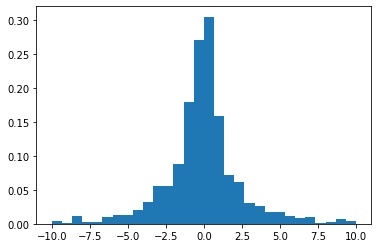

In [41]:
samp = cauchy_rnd(0, 1, 1000)
plt.hist(samp, density=True, bins=30, range=(-10, 10))
plt.show

#### 2. На основе датчика распределения Коши с помощью метода фон Неймана построить датчик стандартного нормального распределения. Убедиться в корректности построенного датчика и обосновать наблюдаемую линейную зависимость.

Описание метода элиминации фон Неймана.

Пусть имеется датчик распределения с плотностью $g(\cdot)$ (в этой задаче 
$g(x) = \frac{\gamma}{\pi[(x - x_0)^2 + \gamma^2]}$), и требуется смоделировать случайную величину с плотностью $f(\cdot)$ ($f(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$), причем
$$\sup_x \frac{f(x)}{g(x)} \leq k.$$

Будем использовать следующий алгоритм:
1. Моделируем $X \sim g$ и равномерно распределенную на единичном отрезке случайную  величину $U$.
2. Если $$\frac{f(X)}{g(X)} \geq kU,$$
то $Y = X$, и процесс завершается, в противном случае нужно вернуться у шагу 1.

Полученная таким образом случайная величина $Y$ имеет требуемое распределение $f$.

Нетрудно показать, что наилучшее приближение стандартного нормального распределения распределением Коши имеет параметры $x_0 = 0, \gamma = 1$. При этом
$$k = \sup_x \frac{f(x)}{g(x)} = \sqrt{2\pi}e^{-\frac12}.$$

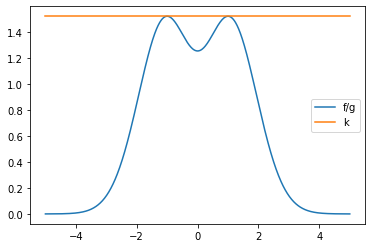

In [42]:
k = np.sqrt(2 * np.pi) * np.exp(-0.5)
x = np.linspace(-5, 5, 1000)
f = 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)
g = 1 / (np.pi * (x**2 + 1))
plt.plot(x, f / g, label='f/g')
plt.plot([-5, 5], [k, k], label='k')
plt.legend()
plt.show()

In [43]:
def norm_neumann_rnd(mu, sigma, out_size):
    res = np.zeros(0)
    while res.size < out_size:
        u = np.random.random_sample(out_size)
        x = cauchy_rnd(0, 1, out_size)
        k = np.sqrt(2 * np.pi) * np.exp(-0.5)
        f = 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)
        g = 1 / (np.pi * (x**2 + 1))
        res = np.concatenate([res, x[f / g >= k * u]])
    return sigma * res[0:out_size] + mu

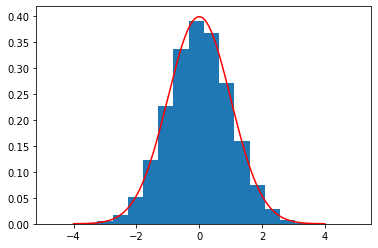

In [44]:
samp = norm_neumann_rnd(0, 1, 10**6)
plt.hist(samp, density=True, bins=20)
x = np.linspace(-4, 4, 1000)
plt.plot(x, norm.pdf(x), c='r')
plt.show()

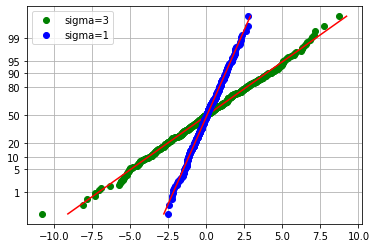

In [45]:
from scipy import stats

samp = norm_neumann_rnd(0, 1, 500)
(quants, vals), (slope, inter, r) = stats.probplot(samp, dist='norm')

samp2 = norm_neumann_rnd(0, 3, 500)
(quants2, vals2), (slope2, inter2, r2) = stats.probplot(samp2, dist='norm')

plt.plot(vals2, quants2, 'og', label='sigma=3')
plt.plot(quants2 * slope2 + inter2, quants2, 'r')

plt.plot(vals, quants, 'ob', label='sigma=1')
plt.plot(quants * slope + inter, quants, 'r')

ticks_perc=[1, 5, 10, 20, 50, 80, 90, 95, 99]
ticks_quan=[stats.norm.ppf(i/100.) for i in ticks_perc]
plt.yticks(ticks_quan,ticks_perc)

plt.legend()
plt.grid()
plt.show()

Для стандартного нормального распределения точки лежат на прямой по построению: ось ординат деформируется так, чтобы функция нормального распределения была линейной. Таким образом, если $\xi \sim \mathcal{N}(0, 1)$, то $F(x) = \mathbb{P}(\xi < x)$ линейна на таком графике. Произвольную нормальную случайную величину можно представить в виде $\eta = \sigma \xi + \mu$, и для нее
$$\mathbb{P}(\eta < x) = \mathbb{P}\left(\xi < \frac{x - \mu}{\sigma}\right)$$
также будет линейной на этом графике.

#### 3. Сравнить скорость моделирования стандартного нормального распределения в заданиях 3 и 4

<function matplotlib.pyplot.show(*args, **kw)>

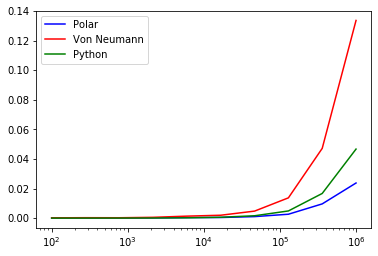

In [46]:
from time import time

n = 10
sizes = np.logspace(2, 6, n).astype(int)
times_pol = np.zeros((10, n))
times_neum = np.zeros((10, n))
times_python = np.zeros((10, n))
for s in enumerate(sizes):
    for i in range(0, 10):
        t = time()
        norm_polar_rnd(0, 1, s[1])
        times_pol[i][s[0]] = time() - t
        t = time()
        norm_neumann_rnd(0, 1, s[1])
        times_neum[i][s[0]] = time() - t
        t = time()
        np.random.randn(s[1])
        times_python[i][s[0]] = time() - t
times_pol = np.median(times_pol, axis=0)
times_neum = np.median(times_neum, axis=0)
times_python = np.median(times_python, axis=0)
plt.plot(sizes, times_pol, label='Polar', c='b')
plt.plot(sizes, times_neum, label='Von Neumann', c='r')
plt.plot(sizes, times_python, label='Python', c='g')
plt.legend()
plt.xscale("log")
plt.show

# Задание 5

#### 1. Пусть $X_i \sim \mathcal{N}(\mu, \sigma^2)$. Убедиться эмпирически в справедливости ЗБЧ и ЦПТ: исследовать поведение суммы $S_n$ и эмпирического распределения величины
$$\sqrt{n}\left(\frac{S_n}{n} - a\right).$$

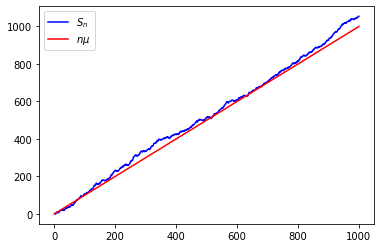

In [47]:
n = 10**3
mu = 1
sigma = 2
samp = norm_polar_rnd(mu, sigma, n)
sn = samp.cumsum()
x = np.array(range(1, n + 1))
plt.plot(x, sn, 'b', label=r'$S_n$')
plt.plot(x, x * mu, 'r', label=r'$n\mu$')
plt.legend()
plt.show()

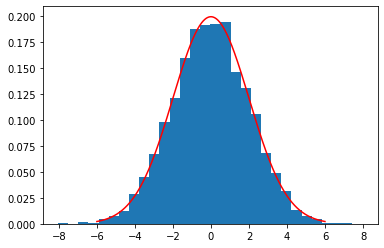

In [48]:
samp_sz = 10**4
samp = (norm_polar_rnd(mu, sigma, (n, samp_sz)).sum(0) / n - mu) * np.sqrt(n)
plt.hist(samp, density=True, bins=30)
x = np.linspace(-6, 6, 1000)
plt.plot(x, 1 / sigma * norm.pdf(x / sigma), c='r')
plt.show()

По ЦПТ распределение $\sqrt{n}\left(\frac{S_n}{n} - a\right)$ стремится по распределению к $\mathcal{N}(0, \sigma^2)$.

#### 2. Считая $\mu$ и $\sigma$ неизвестными, для пункта 1 построить доверительные интервалы для среднего и дисперсии.

Так как статистика $$U = \sqrt{n}\frac{\bar X - \mu}{\sigma'}, \quad \sigma' = \frac{1}{n-1}\sum_i(X_i - \bar X)^2$$
имеет распределение Стьюдента с $n - 1$ степенью свободы, можно построить доверительный интервал с уровнем доверия $\alpha = 0.95$ следующим образом:
$$\mathbb{P}(\gamma_1 < U < \gamma_2) = \mathbb{P}\left(\bar X - \frac{\sigma'\gamma_2}{\sqrt{n}} < \mu < \bar X - \frac{\sigma'\gamma_1}{\sqrt{n}}\right) = 1 - \alpha.$$
Значения $\gamma_1$ и $\gamma_2$ выберем так, чтобы интервал был симметричным:
$$\gamma_1 = T^{-1}_{n-1}\left(\frac{1 - \alpha}{2}\right),\  \gamma_2 = T^{-1}_{n-1}\left(\frac{1 + \alpha}{2}\right).$$
Итак, доверительный интервал для параметра $\mu$ имеет вид
$$\left(\bar X - \frac{\sigma'\gamma_2}{\sqrt{n}}, \ \bar X - \frac{\sigma'\gamma_1}{\sqrt{n}}\right).$$

In [49]:
from scipy.stats import t

alpha = 0.95
n = 1000
gamma1 = t.ppf((1 - alpha) / 2, n - 1)
gamma2 = t.ppf((1 + alpha) / 2, n - 1)
print(gamma1, gamma2)

-1.9623414611334487 1.9623414611334487


In [50]:
mu = 1
sigma = 2
in_inter = 0

test_sz = 100
for i in range(0, test_sz):
    samp = norm_polar_rnd(mu, sigma, n)
    s = np.sqrt(samp.var() * n / (n - 1))
    A = samp.mean() - gamma2 * s / np.sqrt(n)
    B = samp.mean() - gamma1 * s / np.sqrt(n)
    if mu > A and mu < B:
        in_inter += 1
        
print('Mu lies in confidence interval in ', 100 * in_inter / test_sz, '% of tests.')

Mu lies in confidence interval in  92.0 % of tests.


Для оценки дисперсии будем использовать статистику
$$V = \frac{\sum_i(X_i - \bar X)^2}{\sigma^2} \sim \chi^2(n - 1).$$
Пусть снова $\alpha = 0.95$. 
$$\mathbb{P}(\gamma_1 < V < \gamma_2) = \mathbb{P}\left(\frac{\sum_i(X_i - \bar X)^2}{\gamma_2} < \sigma^2 < \frac{\sum_i(X_i - \bar X)^2}{\gamma_1}\right) = 1 - \alpha.$$
Для построения симметричного интервала
$$\gamma_1 = \chi^{-1}\left(\frac{1-\alpha}{2}\right), \ \gamma_2 = \chi^{-1}\left(\frac{1+\alpha}{2}\right).$$
Доверительный для $\sigma^2$ с уровнем доверия $\alpha$ имеет вид
$$\left(\frac{\sum_i(X_i - \bar X)^2}{\gamma_2}, \ \frac{\sum_i(X_i - \bar X)^2}{\gamma_1}\right).$$

In [51]:
alpha = 0.95
n = 1000
gamma1 = chi2.ppf((1 - alpha) / 2, n - 1)
gamma2 = chi2.ppf((1 + alpha) / 2, n - 1)
print(gamma1, gamma2)

913.3009983021134 1088.4870677259353


In [52]:
mu = 1
sigma = 2
in_inter = 0

test_sz = 100
for i in range(0, test_sz):
    samp = norm_polar_rnd(mu, sigma, n)
    A = n * samp.var() / gamma2
    B = n * samp.var() / gamma1
    if sigma**2 > A and sigma**2 < B:
        in_inter += 1
        
print('Variance lies in confidence interval in ', 100 * in_inter / test_sz, '% of tests.')

Variance lies in confidence interval in  95.0 % of tests.


#### 3. Пусть $X_i \sim \mathcal{C}(a, b)$ имеет распределение Коши со сдвигом $a$ и масштабом $b$. Проверить эмпирически, как ведут себя суммы $\frac{S_n}{n}$. Результат объяснить, а также найти распределения данных сумм.

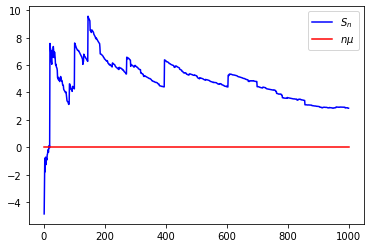

In [53]:
n = 10**3
a = 1
b = 2
samp = cauchy_rnd(a, b, n)
sn = samp.cumsum()
x = np.array(range(1, n + 1))
plt.plot(x, sn / x, 'b', label=r'$S_n$')
plt.plot(x, a * np.zeros(x.shape), 'r', label=r'$n\mu$')
plt.legend()
plt.show()

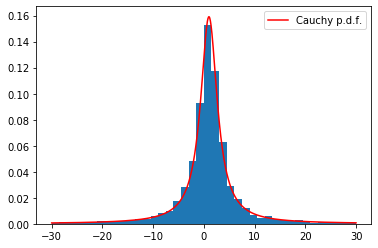

In [54]:
samp_sz = 10**4
samp = (cauchy_rnd(mu, sigma, (n, samp_sz)).sum(0) / n)
plt.hist(samp, density=True, bins=40, range=(-30, 30))
x = np.linspace(-30, 30, 1000)
plt.plot(x, 1 / np.pi * b / ((x - a)**2 + b**2), 'r', label='Cauchy p.d.f.')
plt.legend()
plt.show()

Найдем распределение $\frac{S_n}{n}$ с помощью характеристической функции распределения Коши:
$$\varphi(t) = \mathbb{E}e^{it\xi} = \frac1\pi\int\frac{be^{itx}}{(x - a)^2 + b^2}dx = \frac{e^{ita}}{\pi}\int\frac{e^{itbx}}{x^2 + 1}dx = e^{ita - |t|b}.$$
Тогда характеристическая функция $\frac{S_n}{n}$ имеет вид
$$\varphi_{\frac{S_n}{n}}(t) = \left[\varphi\left(\frac{t}{n}\right)\right]^n = \varphi(t),$$
поэтому $\frac{S_n}{n} \sim \mathcal{C}(a, b)$.

# Задание 6

#### 1. Посчитать интеграл
$$J = \int\limits_{-\infty}^{+\infty}\int\limits_{-\infty}^{+\infty}\ldots\int\limits_{-\infty}^{+\infty} \dfrac{e^{-\left(x_1^2 + \ldots + x_{10}^2 + \frac{1}{2^7x_1^2\ldots x_{10}^2}\right)}}{x_1^2\ldots x_{10}^2}dx_1dx_2\ldots dx_{10}$$

#### a) методом Монте-Карло;

#### b) методом квадратур, сводя задачу к вычислению собственного интеграла Римана.

a) Отметим, что случайный вектор $X = (X_1, \ldots, X_{10})$, у которого каждая компонента распределена нормально с $\mu = 0,\ \sigma^2 = \frac12$, имеет плотность
$$p(x) = \frac{1}{\pi^5}e^{-(x_1^2 + \ldots + x_{10}^2)}.$$
Перепишем интеграл в виде
$$ J = \pi^5 \int\limits_{\mathbb{R}^{10}} ye^{-\frac{y}{128}}p(x)dx, \quad y = \left(\prod_{k=1}^{10} x_k\right)^{-2}$$
и заметим, что он равен математическому ожиданию
$\mathbb{E}f(Y),$
где $f(y) = \pi^5 y e^{-\frac{y}{128}},\ Y = \left(\prod_{k=1}^{10} X_k\right)^{-2}$, а $X_k \sim \mathcal{N}\left(0, \frac12\right)$ и независимы.

По ЗБЧ $\frac1n \sum_k f(y_k) \to \mathbb{E}f(Y) = J$.

In [55]:
def int_func(x):
    return np.pi ** 5 * x * np.exp(-x / 128)

In [56]:
n = 10**6
res = int_func(norm_polar_rnd(0, 1 / np.sqrt(2), (10, n)).prod(0)**(-2)).mean()
print(res)

125.8431301744299


При $n = 10^7$ метод Монте-Карло дает результат $J \approx 124.8$.

b) Сделаем в интеграле замену $x_k = \tan\left(y_k\right), \ dx_k = \dfrac{dy_k}{\cos^2\left(y_k\right)}, \ k = 1, \ldots, 10.$
После замены и некоторых упрощений интеграл примет вид
$$\int\limits_{-\frac{\pi}{2}}^{\frac{\pi}{2}}\ldots\int\limits_{-\frac{\pi}{2}}^{\frac{\pi}{2}} \exp \left\{-\sum\limits_k \tan^2(y_k) - \dfrac{1}{128}\prod\limits_k \cot^2 (y_k)\right\}\prod\limits_k \dfrac{1}{\sin^2(y_k)}dy_1\ldots dy_{10}$$

Обозначим подынтегральную функцию $f(y_1, \ldots, y_{10})$ и заметим, что она симметрична по всем аргументам.

Построим равномерную сетку размера $m$ на каждом отрезке $\left[-\dfrac{\pi}{2}, \dfrac{\pi}{2}\right]$:
$$x_i = -\frac{\pi}{2} + h(i + 0.5), \quad i = 0, \ldots, m-1,$$
$h = \dfrac{\pi}{m}$ - шаг сетки. Элементы сетки - центры отрезков, полученных при разбиении $\left[-\dfrac{\pi}{2}, \dfrac{\pi}{2}\right]$ на $m$ равных частей. Разобьем $\left[-\dfrac{\pi}{2}, \dfrac{\pi}{2}\right]^{10}$ на гиперкубики с центрами $(x_{i_1}, \ldots, x_{i_{10}}),\ i_k = 0, \ldots, m-1,\ k = 1, \ldots, 10$ и мерой $h^{10}$ и воспользуемся методом прямоугольников
$$J \approx h^{10}\sum_{i_1=0}^{m-1}\ldots\sum_{i_{10}=0}^{m-1}f(x_{i_1}, \ldots, x_{i_{10}})$$

Для вычисления этой суммы потребуется $m^{10}$ вычислений функции $f$, что уже при $m = 5$ потребует около $10^7$ итераций. Для оптимизации вычислений воспользуемся симметричностью $f$:
$$J \approx \sum_{0 \leq i_1 \leq \ldots \leq i_{10} \leq m-1} \dfrac{10!}{n_0!\ldots n_{m-1}!}f(x_{i_1}, \ldots, x_{i_{10}}),$$
где $n_i$ обозначается число индексов, равных $i$ на данной итерации. Число слагаемых при этом равно ${m + 9 \choose 10}$. 

In [57]:
import itertools

def comb(n, k):
    return len(list(itertools.combinations(range(1, n + 1), k)))

In [58]:
m = 12
print(comb(9 + m, 10))

352716


In [59]:
def terrible_func(y):
    tans = np.tan(y)**2
    return np.exp(-tans.sum() - np.prod(1 / tans) / 128) * np.prod(1 / (np.sin(y))**2)

In [60]:
def fact(n):
    if n == 0:
        return 1
    return np.prod(range(1, n + 1))

In [61]:
def pol_coef(ns):
    return int(fact(ns.sum()) / np.array([fact(i) for i in ns]).prod())

In [62]:
def next_str(s, m): # возвращает следующую неубываюзую целочисленную последовательность с элементами 0 <= x_i < m.
    for i in range(-1, -len(s) - 1, -1):
        if s[i] < m - 1:
            s[i:] = (s[i] + 1) * np.ones(s[i:].shape)
            return s
    return -1

In [63]:
m = 6
ii = np.zeros(10).astype(int)
ns = np.zeros(m)
h = np.pi / m
x = [-np.pi / 2 + h * (i + 0.5) for i in range(0, m)]
res = 0
n_time = 0
res_time = 0
next_time = 0
while 1:
    ns = np.array([(ii == i).sum() for i in range(0, m)])
    res += pol_coef(ns) * terrible_func(np.array([x[i] for i in ii]))
    ii = next_str(ii, m)
    if np.prod(ii == -1):
        break
res *= h**10
print(res)

272.60289753370716


При $m = 12$ приближенное решение $J \approx 120$ близко к результату, полученному при помощи метода Монте-Карло, однако требует значительно больше вычислений.

#### 2. Для каждого случая оценить точность вычислений.

a) Для метода Монте-Карло найдем ошибку $\varepsilon$, вероятность превзойти которую при моделировании выборки размера $n$ не превосходит $\alpha$. Воспользуемся для этого неравентсвом Чебышёва:
$$\mathbb{P}\left(\left|\dfrac{1}{n}\sum_{k=1}^nf(Y_k) - \mathbb{E}f(Y)\right| \geq \varepsilon \right) \leq \dfrac{\mathrm{var} [f(Y)]}{n\varepsilon^2} = \alpha.$$

Дисперсию $f(Y)$ будем аппроксимировать выборочной дисперсией $\dfrac{1}{n}\sum\limits_i (f(Y_i) - \overline{f(Y)})^2$, которая является состоятельной оценкой.

In [64]:
n = 10**7
var = int_func(norm_polar_rnd(0, 1 / np.sqrt(2), (10, n)).prod(0)**(-2)).var()
print(var)

1302285.149160931


Положим $\alpha = 0.05, \ n = 10^7$. Тогда 
$\varepsilon = \sqrt{\dfrac{\mathrm{var} [f(Y)]}{n\alpha}}.$

In [65]:
alpha = 0.05
eps = np.sqrt(var / n / alpha)
print(eps)

1.6138681167684865


b) Для оценки погрешности будем использовать разложение в ряд Тейлора с остаточным членом в форме Лагранжа функции $f$:
$$f(y) = f(y_0) + \langle \nabla f(\xi), \ \Delta y\rangle,$$
где $y_0$ центр гиперкубика $\Delta$, a $\xi \in \Delta$. Интегрируя обе части по $\Delta$, получим, что ошибка интегрирования по каждому кубику равна
$$\int\limits_\Delta \langle \nabla f(\xi), \ \Delta y\rangle dy \leq \sup_\Delta \|\nabla f(x)\|\|\Delta y\|\mu(\Delta) \leq \dfrac{\sqrt{n}}{2}h^{n+1}\sup_{\left[-\frac{\pi}2, \frac{\pi}2\right]} \|\nabla f(x)\|,$$
а общая ошибка не превосходит $\dfrac{\pi^nh\sqrt{n}}{2}\sup\limits_{\left[-\frac{\pi}2, \frac{\pi}2\right]} \|\nabla f(x)\|$, то есть убывает линейно по $h$, однако высокая размерность требует для достижения необходимой точности такого малого значения $h$, что вычисление квадратурной формулы не представляется возможным.

# Задание 7

#### 1. Методом случайного поиска найти минимальное значение функции $f$ на множестве $A = \left\{(x_1, x_2)\colon \ x_1^2 + x_2^2 \leq 1\right\}$, где 
#### $$f(x_1, x_2) = x_1^3\sin\left(\dfrac{1}{x_1}\right) + 10x_1x_2^4 \cos\left(\dfrac{1}{x_2}\right),$$
#### $f(0, 0) = 0$ по непрерывности.

In [66]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


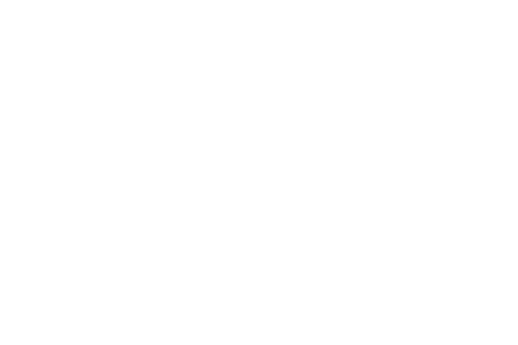

<IPython.core.display.Javascript object>


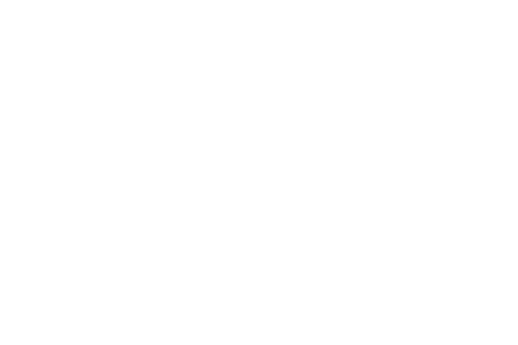

In [67]:
x, y = np.mgrid[-1:1:0.00101, -1:1:0.00101]
z = x**3 * np.sin(1 / x) + 10 * x * y**4 * np.cos(1 / y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='inferno')

In [68]:
def opt_fun(x, y):
    return x**3 * np.sin(1 / x) + 10 * x * y**4 * np.cos(1 / y)

Будем генерировать $n$ равномерно распределенных по окружности $A$ независимых случайных величин $X_1, \ldots X_n$ и выбирать в качестве решения ту, на которой минимизируется значение $f$.

Найдем распределение полярных координат при равномерном распределении по окружности:
$$\mathbb{P}(X \in B) = \dfrac{1}{\pi}\iint\limits_Bdxdy = \dfrac{1}{\pi}\iint\limits_Brdrd\varphi = \iint\limits_Bdr^2d\left(\dfrac{\varphi}{2\pi}\right),$$
откуда можно сделать вывод, что $\varphi \sim \mathcal{U}(0, 2\pi)$, а $r$ имеет функцию распределения
$$F_r(x) = 
\begin{cases}
0, &x < 0, \\
x^2, &x \in [0, 1], \\
1, &x > 1.
\end{cases}$$

Для моделирования $r$ будем использовать метод обращения функции распределения:
$$r \overset{d}{=} \sqrt{U}, \quad U \sim \mathcal{U}[0, 1].$$

In [69]:
n = 10**7
loop_sz = 1
fmin = 1
amin = [0, 0]

for i in range(0, loop_sz):
    phi = np.random.rand(n) * 2 * np.pi
    r = np.sqrt(np.random.rand(n))
    f = opt_fun(r * np.cos(phi), r * np.sin(phi))
    cur_min = np.min(f)
    if cur_min < fmin:
        fmin = cur_min
        amin = [r[np.argmin(f)] * np.cos(phi[np.argmin(f)]), r[np.argmin(f)] * np.sin(phi[np.argmin(f)])]
print('min f = ', fmin, '\nargmin f = ', amin)

min f =  -1.2881435391793767 
argmin f =  [-0.35498226656247406, 0.9348403709735585]


Оценим точность реализованного метода. Пусть $x^* = \underset{x \in A}{\operatorname{argmax}}  f(x)$. Потребуем, чтобы для найденного решения $x$ выполнялось $|f(x^*) - f(x)| < \varepsilon$ с вероятностью $\alpha$. Так как фунцкция $f$ является непрерывно дифференцируемой в $A$, верна оценка
$$|f(x^*) - f(x)| \leq \|\nabla f(x^*)\| \|x - x^*\| \leq \sup_A \|\nabla f(x)\|\|x - x^*\| \leq \varepsilon$$
при $\|x - x^*\| \leq \delta = \dfrac{\varepsilon}{\sup\limits_A \|\nabla f(x)\|}$.

Оценим величину $\sup\limits_A \|\nabla f(x)\|$.
$$\dfrac{\partial f}{\partial x_1} = 3x_1^2\sin\left(\dfrac{1}{x_1}\right) - x_1\cos\left(\dfrac{1}{x_1}\right) + 10x_2^4\cos\left(\dfrac{1}{x_2}\right),$$
$$\dfrac{\partial f}{\partial x_2} = 40x_1x_2^3 \cos\left(\dfrac{1}{x_2}\right) + 10x_1x_2^2\sin\left(\dfrac{1}{x_2}\right),$$
$$\|\nabla f(x)\| = \sqrt{\left(\dfrac{\partial f}{\partial x_1}\right)^2 + \left(\dfrac{\partial f}{\partial x_2}\right)^2} \leq \sqrt{14^2 + 50^2} \leq 52.$$
Выберем число испытаний так, чтобы хотя бы один элемент выборки оказался в $\delta$-окрестности $x^*$ с вероятностью не менее $\alpha$. Учтем также, что $x^*$ может лежать на границе круга, и при малых $\delta$ окрестность $B_\delta(x^*) \bigcap A$ можно аппроксимировать полуокружностью.

$$\mathbb{P}(X_k \notin B_\delta(x^*), \ \ k = 1, \ldots, n) \leq \left(1 - \dfrac{\delta^2}{2}\right)^n \leq 1 - \alpha,$$
откуда $n = \dfrac{\ln(1 - \alpha)}{\ln\left(1 - \dfrac{\delta^2}{2}\right)}$

Положим $\varepsilon = 0.01, \alpha = 0.99$. Тогда $\delta = \dfrac{0.01}{52}, \ n = 2.5 \cdot 10^8$.
При таких параметрах результат работы метода $f_* = -1.288$.

In [70]:
delta = 0.01/52
alpha = 0.99
n = np.log(1 - alpha) / np.log(1 - delta**2 / 2)
print(n)

249047600.84305027


#### 2. Методом имитации отжига найти минимальное значение функции Розенброка $g$ в пространстве $\mathbb{R}^2$, где
$$g(x) = (x_1 - 1)^2 + 100(x_2 - x_1^2)^2.$$

In [71]:
def rosenbrock(x, y):
    return (x - 1)**2 + 100 * (y - x**2)**2

Функция Розенброка имеет глобальный минимум в точке $(1, 1)$.

<IPython.core.display.Javascript object>


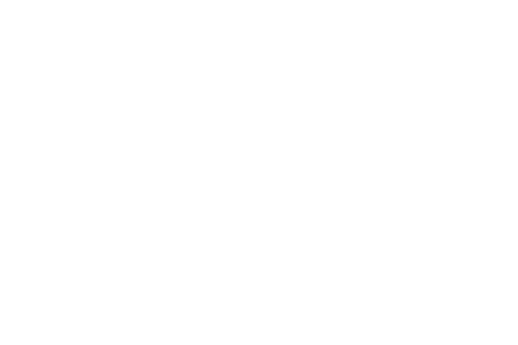

<IPython.core.display.Javascript object>


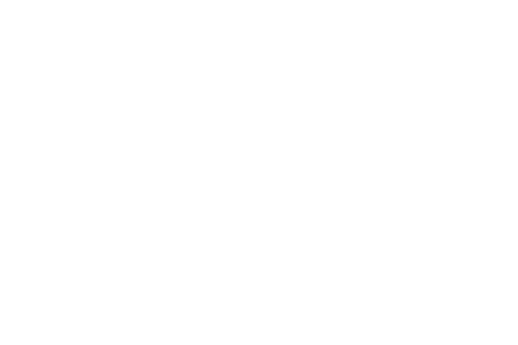

In [72]:
x, y = np.mgrid[0.5:1.5:0.0101, 0.5:1.5:0.0101]
z = rosenbrock(x, y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='inferno')

In [73]:
%matplotlib inline

Описание алгоритма.

0. Задаются входные параметры $m, \sigma, t_0$ и начальное значение $(x_0, y_0)$.
1. Генерируется кандидат на следующий шаг $(x_{k+1}, y_{k+1}) \sim (\mathcal{N}(x_k, t_k\sigma^2), \mathcal{N}(y_k, t_k\sigma^2))$ и вычиляется приращение функции $\Delta g = g(x_{k+1}, y_{k+1}) - g(x_k, y_k)$.
2. В случае, если $\Delta g < 0$, делается шаг в $(x_{k+1}, y_{k+1})$.
В противном случае переход выполняется с вероятностью $p_k = \dfrac{1}{1 + \exp\left\{\dfrac{\Delta g}{t_k}\right\}}$.
3. Понижается температура по закону
$$t_{k+1} = t_k m^{\dfrac{1}{1+0.1|\Delta g|}}.$$
Такое правило позволяет медленнее понижать температуру в случае, когда начальное приближение далеко от решения, и приращения функции велики.

In [74]:
def annealing(func, sigma, k, t0, x0, y0):
    start = time()
    t = t0
    cur_f = func(x0, y0)
    x = x0
    y = y0
    iterations = 0
    steps = 0
    while t > 10**(-5):
        iterations += 1
        x_new = norm_polar_rnd(x, sigma * np.sqrt(t), 1)
        y_new = norm_polar_rnd(y, sigma * np.sqrt(t), 1)
        f_new = func(x_new, y_new)
        df = f_new - cur_f
        if df < 0:
            x = x_new
            y = y_new
            cur_f = f_new 
            steps += 1
        else:
            p = 1 / (1 + np.exp(df / t))
            if np.random.rand() < p:
                x = x_new
                y = y_new
                cur_f = f_new 
                steps += 1
        t *= k ** (1 / (1 + 0.1* abs(df)))
    return [cur_f[0], x[0], y[0], steps / iterations, time() - start, iterations]

In [75]:
sigma = 2.7
k = 0.995
t0 = 2
x0 = 10
y0 = 5
print(annealing(rosenbrock, sigma, k, t0, x0, y0))

[1.3263217617057517e-05, 0.9986861901471119, 0.9970344430088427, 0.00785269428648795, 1.147078275680542, 11079]


Так как аналитическая оценка точность алгоритма затруднительна, оценим точность исходя из распределения ошибки $\|x - x^*\|$.

На гистограмме показаны ошибки $\|x - x^*\|$. По выборке размера $n = 1000$ вычислим квантиль порядка $0.99$.

На гистограмме показано распределение ошибки $\|f(x) - f(x^*)\|$. Квантиль порядка $0.99$ равен

#### 3. Оценить точность. Сравнить результаты со стандартными методами оптимизации.

Проверим результат метода имитации отжига методом сопряженных градиентов.

In [76]:
from scipy.optimize import minimize, rosen
import scipy

x0 = [5, 5]
res = minimize(rosen, x0, method='CG', tol=1e-6)
print(res)

     fun: 2.0087517606575458e-12
     jac: array([4.55523459e-07, 2.83432080e-06])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 367
     nit: 23
    njev: 89
  status: 2
 success: False
       x: array([0.99999858, 0.99999718])


Задачу минимизации из пункта 1 будем решать методом COBYLA (Constrained Optimization BY Linear Approximation).

In [77]:
def opt_fun_1(x):
    return x[0]**3 * np.sin(1 / x[0]) + 10 * x[0] * x[1]**4 * np.cos(1 / x[1])

In [78]:
x0 = [-0.2, -0.8]
cnst = scipy.optimize.NonlinearConstraint(lambda x: (x**2).sum(), 0, 1)
res = minimize(opt_fun_1, x0, method='COBYLA', tol=1e-6, constraints=cnst)
res

     fun: -1.288489227610783
   maxcv: 2.90745205688836e-12
 message: 'Optimization terminated successfully.'
    nfev: 59
  status: 1
 success: True
       x: array([-0.35735285, -0.93396945])

При начальном приближении, далеком от $x^*$, функция возвращает неверный результат.

In [79]:
x0 = [0.2, 0.1]
cnst = scipy.optimize.NonlinearConstraint(lambda x: (x**2).sum(), 0, 1)
res = minimize(opt_fun_1, x0, method='COBYLA', tol=1e-6, constraints=cnst)
res

     fun: -0.012217243593008359
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 49
  status: 1
 success: True
       x: array([ 0.24551919, -0.11102656])

# Задание 8

#### 1. Применить метод Монте-Карло к решению первой краевой задачи для двумерного уравнения Лапласа в единичном круге:
$$
\begin{cases}
\Delta u = 0, \quad (x, y) \in D = \{(x, y)\colon \ \ x^2 + y^2 \leq 1\}\\
u|_{\partial D} = f(x, y) \\
u \in C^2(D), \ f \in C(\partial D)
\end{cases}
$$

#### Для функции $f(x, y) = x^2 - y^2$ найти аналитическое решение и сравнить с полученным по методу Монте-Карло.

Введем на плоскости сетку $x_{ij} = (-1 + ih, -1 + jh)$ с шагом $h$ и назовем внутренними узлы, для которых все 4 соседних узла лежат в круге. Узлы, лежащие в круге, но не удовлетворяющие этому условию, будем называть крайними. 

Аппроксимируя вторые частные производные, можно свести задачу Дирихле к следующей разностной схеме:
$$u_{ij} = \dfrac14(u_{i-1,j} + u_{i+1, j} + u_{i, j-1} + u_{i,j+1}) \text{ для внутренних узлов},$$
$$u_{ij} = f_{ij} \text{ для крайних узлов}.$$

Рассмотрим теперь следующую модель случайного блуждания: 
1. Частица начинает свой путь во внутреннем узле $x_{ij}$.
2. С равными вероятностями она переходит в один из четырех соседних узлов.
3. Процесс продолжается до тех пор, пока частица не попадет на крайний узел $x_{pq}$.

Обозначим $p(x_{ij}, x_{pq})$ вероятность, начав путь в узле $x_{ij}$, закончить его в узле $x_{pq}$. Из формулы полной вероятности следует
\begin{equation}
p(x_{ij}, x_{pq}) = \dfrac14(p(x_{i-1,j}, x_{pq}) + p(x_{i+1, j}, x_{pq}) + p(x_{i, j-1}, x_{pq}) + p(x_{i,j+1}, x_{pq}))
\end{equation}
для внутренних узлов $x_{ij}$ и $p(x_{ij}, x_{ij}) = 1$ для крайних узлов.

Рассмотрим теперь случайную величину $\xi_{ij} = f(x_{pq})$ - значение $f$ в конечной точке пути.
Так как $\mathbb{E}\xi_{ij} = \sum_{p, q}p(x_{ij}, x_{pq})f(x_{pq})$, используя формулу связи вероятностей на соседних узлах, получим
$$\mathbb{E}\xi_{ij} = \dfrac14(\mathbb{E}\xi_{i-1,j} + \mathbb{E}\xi_{i+1, j} + \mathbb{E}\xi_{i, j-1} + \mathbb{E}\xi_{i,j+1}) \text{ для внутренних узлов,}$$
$$\mathbb{E}\xi_{ij} = f_{ij} \text{ для крайних}.$$

Видно, что эти уравнения совпадают с разностной схемой, аппроксимирующей исходную задачу.

Значения $\mathbb{E}\xi_{ij}$ в каждом узле можно вычислить методом Монте-Карло, моделируя описанный выше случайных процесс.

In [80]:
def dirichlet_monte_carlo(x, y, f, n, h):
    res = 0
    for i in range(0, n):
        cur_x = x
        cur_y = y
        while cur_x**2 + cur_y**2 + h**2 + 2 * h * max(abs(cur_x), abs(cur_y)) <= 1:
            if np.random.randint(2):
                cur_x += 2 * h * (np.random.randint(2) - 0.5)
            else:
                cur_y += 2 * h * (np.random.randint(2) - 0.5)
        res += f(cur_x, cur_y)
    return res / n

Для оптимизации вычислений воспользуемся тем, что моделируемый случайный процесс обладает марковским свойством: его "будущее" не зависит от "прошлого", поэтому при прохождении траектории через промежуточные узлы дальнейший путь частицы можно рассматривать как процесс, начавшийся в этом промежуточном узле.

In [81]:
def dirichlet_monte_carlo_matrix(X, Y, f, n, h):
    idx = X**2 + Y**2 <= 1
    res = np.zeros(X.shape)
    N = np.ones(X.shape) * np.inf
    N[idx] = 0
    passed = np.zeros(X.shape)
    while np.min(N) < n:
        passed[passed > 0] = 0
        (i, j) = np.unravel_index(N.argmin(), N.shape)
        passed[i][j] += 1
        while 1 - 2 * (i + j) * h + (i**2 + j**2) * h**2 < 0 and i > 0 and j > 0 and i < 39 and j < 39:
            if np.random.randint(2):
                i += int(2 * (np.random.randint(2) - 0.5))
            else:
                j += int(2 * (np.random.randint(2) - 0.5))
            passed[i][j] += 1
        res[passed > 0] += f(X[i][j], Y[i][j]) * passed[passed > 0]
        N[passed > 0] += passed[passed > 0]
    Z = np.ones(X.shape) * np.inf    
    Z[idx] = res[idx] / N[idx]
    return Z

График аналитического решения

<IPython.core.display.Javascript object>


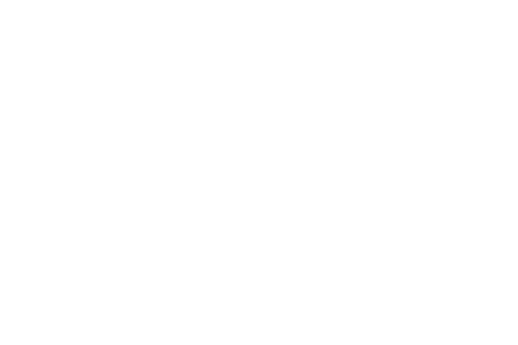

<IPython.core.display.Javascript object>


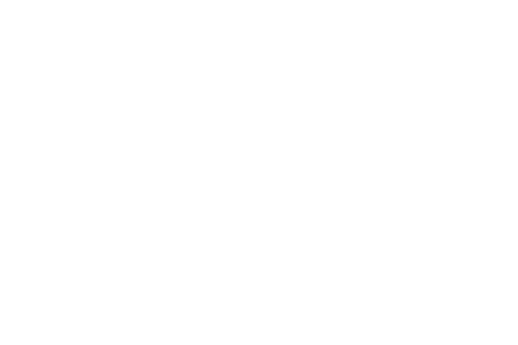

In [82]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
h = 0.05
X, Y = np.mgrid[-1:1:h, -1:1:h]
Z = X**2 - Y**2
X[X**2 + Y**2 > 1] = np.inf
ax.plot_surface(X, Y, Z, cmap='inferno')

# Задание 9

#### Рассмотреть два вида процессов:
- Винеровский процесс $W(t), t \in [0, 1], \ W(0) = 0.$

- Процесс Орнштейна-Уленбека $X(t),\ t \in [0, 1], \ X(0) = X_0$, то есть стационарный марковский гауссовский процесс. Начальное значение $X_0$ генерируется случайным образом так, чтобы полученный процесс бы стационарным.

#### Для данных процессов
1. Найти ковариационную функцию и переходные вероятности.
2. Промоделировать независимые траектории процесса с данными переходными вероятностями методом добавления разбиения отрезка.
3. Построить график траекторий.

Опишем кратко метод добавления разбиения отрезка. Пусть требуется смоделировать случайный процесс $X(t)$ на отрезке $[0, 1]$. 
1. Моделирование $X_0 = X(0)$.
2. Моделирование $X(1)$ по условному распределению $[X(1)|X(0)]$.
3. Между каждыми соседними узлами $t_1, t_2$ сетки добавим узел $t = \dfrac{t_1 + t_2}{2}$ и смоделируем процесс в нем, используя условное распределение случайной величины $[X(t)|X(t_1) = x_1, X(t_2) = x_2]$.
4. Повторение пункта 3 до тех пор, пока шаг сетки не станет достаточно мелким.

#### Винеровский процесс

Винеровский процесс - гауссовский процесс с независимыми приращениями такой, что
- $W(0) \overset{\text{п.н.}}{=} 0$
- $W(t + h) - W(t) \sim \mathcal{N}(0, \sigma^2h)$

Найдем его ковариационную функцию функцию:
$$ R(t_1, t_2) = \mathbb{E}W(t_1)W(t_2) = \{t_1 < t_2\} = \mathbb{E}W^2(t_1) + \mathbb{E}[W(t_1) - W(0)][W(t_2 - W(t_1)] = \sigma^2 t_1 + \mathbb{E}W(t_1)\mathbb{E}(W(t_2) - W(t_1)) = \sigma^2 t_1,$$
откуда
$$K(t_1, t_2) = \min(t_1, t_2) \sigma^2.$$

По определению $W(0) = 0, \ [W(1)|W(0)] \sim \mathcal{N}(0, \sigma^2)$. 

Найдем теперь для $t_1 < t_2 < t_3$ распределение $Y = [W(t_2)|W(t_1) = x_1, W(t_3) = x_3]$. 
Так как $W(t)$ имеет нормальное распределение с параметрами $0$ и $\sigma^2t$, $Y$ имеет плотность
$$p_Y(x_2) = \dfrac{p_{123}(x_1, x_2, x_3)}{p_{13}(x_1, x_3)},$$
где $p_{123}$ -совместная плотность $(W(t_1), W(t_2), W(t_3))$, $p_{13}$ - плотность $(W(t_1), W(t_3))$.

Известно, что плотность $n$-мерного нормального распределения с матожиданием $\mu$ и ковариационной матрицей $\Sigma$ имеет вид
\begin{equation}
p(x) = \dfrac{1}{\sqrt{(2\pi)^n|\Sigma|}}\exp\left\{-\frac12 (x - \mu)^T\Sigma^{-1} (x - \mu)\right\}
\end{equation}

Используя полученную для ковариационной функции формулу, получаем
$$
\Sigma_{13} = \sigma^2 \begin{pmatrix} 
t_1 & t_1 \\
t_1 & t_3
\end{pmatrix},
$$
$$
\Sigma_{123} = \sigma^2 \begin{pmatrix}
t_1 & t_1 & t_1 \\
t_1 & t_2 & t_2 \\
t_2 & t_2 & t_3
\end{pmatrix}.
$$

In [83]:
from sympy import symbols, Matrix
import sympy

t1, t2, t3 = symbols('t_1 t_2 t_3', real=True)
x0, x1, x2, x3 = symbols('x_0 x_1 x_2 x_3', real=True)

t2 = (t1 + t3) / 2

S123 = Matrix([[t1, t1, t1], [t1, t2, t2], [t1, t2, t3]])
S13 = Matrix([[t1, t1], [t1, t2]])
x123 = Matrix([[x1], [x2], [x3]])
x13 = Matrix([[x1], [x3]])

p_e = -sympy.Rational(1, 2) * x123.T @ S123.inv() @ x123 + sympy.Rational(1, 2) * x13.T @ S13.inv() @ x13
p_e = p_e[0].simplify()
p_e

(-2*x_1*x_2 + 2*x_1*x_3 + 2*x_2**2 - 2*x_2*x_3)/(t_1 - t_3)

С помощью библиотеки для символьных вычислений sympy найдем
$$p_Y(x_2) = C \exp\left\{ -\dfrac12\dfrac{4}{t_3 - t_1} \left(x_2 - \dfrac{x_1 + x_3}2\right)^2\right\},$$
то есть, обозначая шаг измельченной сетки за $h = t_2 - t_1$, получим $$Y \sim \mathcal{N}\left(\dfrac{x_1 + x_3}{2}, \dfrac{h\sigma^2}{2}\right).$$

#### Процесс Орнштейна-Уленбека

Процесс Орнштейна-Уленбека - это стационарный марковский гауссовский процесс.
Известно, что для такого процесса 
$$\rho(X(t_1), X(t_3)) = \rho(X(t_1), X(t_2))\rho(X(t_2), X(t_3)), \quad t_1 < t_2 < t_3.$$
В силу однородности процесса для любого $t$ верно $X(t) \sim \mathcal{N}(0, \sigma^2)$ (без ограничения общности будем рассматривать центрированный процесс).
Найдем вид функции $K(t) = \rho(X(t), X_0)$, предполагая $0 \leq t_1 < t_2 \leq 1$:
$$ K(t_2) = \rho(X(t_2), X_0) = \rho(X(t_2), X(t_1))\rho(X(t_1), X_0) = K(t_2 - t_1)K(t_1).$$
То есть для любых $t, s$ верно $K(t + s) = K(t)K(s)$. Логарифм этой функции $f(x) = \ln K(x)$ является решением уравнения Коши
$$f(x + y) = f(x) + f(y),$$
и, так как функция $K(t)$ непрерывна и ограничена, она имеет вид
$K(t) = e^{-\lambda t}, \ \lambda > 0$, а ковариационная функция процесса
$$R(t_1, t_2) = \sigma^2 e^{-\lambda |t_2 - t_1|}, \quad \lambda > 0.$$

Сгенерируем $X_0$ как нормальную случайную величину с нулевым матожиданием и дисперсией $\sigma^2$.
Найдем теперь распределение $[X(1)|X_0]$.
Ковариационная матрица для $(X_0, X(1))$ имеет вид 
$$
\Sigma = \sigma^2 \begin{pmatrix} 
1 & e^{-\lambda} \\
e^{-\lambda} & 1
\end{pmatrix}.
$$

In [84]:
lam = sympy.Symbol('lambda')
S = Matrix([[1, sympy.exp(-lam)],
           [sympy.exp(-lam), 1]])
x = Matrix([[x0], [x1]])
p = -sympy.Rational(1, 2) * x.T @ S.inv() @ x
p = p[0].simplify()
sympy.collect(p, x1)

-(x_0*(x_0*exp(lambda) - x_1) + x_1*(-x_0 + x_1*exp(lambda)))/(4*sinh(lambda))

Проведя необходимые расчеты, получаем $$[X(1)|X_0] \sim \mathcal{N}\left(x_0e^{-\lambda}, \sigma^2 (1 -e^{-2\lambda})\right).$$

Найдем теперь распределение $Y = [X(t_2)|X(t_1) = x_1, X(t_3) = x_3],\ t_1 < t_2 < t_3$.

Обозначим шаг новой сетки за $h = t_2 - t_1 = t_3 - t_2$ и, как и в случае винеровского процесса, найдем ковариационные матрицы
$$
\Sigma_{13} = \sigma^2 \begin{pmatrix} 
1 & e^{-2\lambda h} \\
e^{-2 \lambda h} & 1
\end{pmatrix},
$$
$$
\Sigma_{123} = \sigma^2 \begin{pmatrix}
1 & e^{-\lambda h} & e^{-2 \lambda h} \\
e^{-\lambda h} & 1 & e^{-\lambda h} \\
e^{-2\lambda h} & e^{-\lambda h} & 1
\end{pmatrix}.
$$

In [85]:
lam = sympy.Symbol('lambda')
h = sympy.Symbol('h')
S123 = Matrix([[1, sympy.exp(-lam * h), sympy.exp(-2 * lam * h)], 
               [sympy.exp(-lam * h), 1, sympy.exp(-lam * h)],
               [sympy.exp(-2 * lam * h), sympy.exp(-lam * h), 1]])
S13 = Matrix([[1, sympy.exp(-2 * lam * h)], 
              [sympy.exp(-2 * lam * h), 1]])

p_e = -sympy.Rational(1, 2) * x123.T @ S123.inv() @ x123 + sympy.Rational(1, 2) * x13.T @ S13.inv() @ x13
p_e = p_e[0].simplify()
sympy.collect(p_e, x2)

-(x_1**2*exp(2*h*lambda)/2 + x_1*x_3*exp(2*h*lambda) + x_2**2*(exp(4*h*lambda)/2 + exp(2*h*lambda) + 1/2) + x_2*(-x_1*exp(3*h*lambda) - x_1*exp(h*lambda) - x_3*exp(3*h*lambda) - x_3*exp(h*lambda)) + x_3**2*exp(2*h*lambda)/2)/(exp(4*h*lambda) - 1)

In [86]:
b = (sympy.exp(4 * lam * h) - 1) / (sympy.exp(4 * lam * h) + 2 * sympy.exp(2 * lam * h) + 1)
sympy.collect((p_e * (-2 * b)).simplify(), x2)

(x_1**2*exp(2*h*lambda) + 2*x_1*x_3*exp(2*h*lambda) + x_2**2*(exp(4*h*lambda) + 2*exp(2*h*lambda) + 1) + x_2*(-2*x_1*exp(3*h*lambda) - 2*x_1*exp(h*lambda) - 2*x_3*exp(3*h*lambda) - 2*x_3*exp(h*lambda)) + x_3**2*exp(2*h*lambda))/(exp(4*h*lambda) + 2*exp(2*h*lambda) + 1)

После преобразований находим, что $$Y \sim \mathcal{N}\left(\dfrac{x_1 + x_3}{e^{\lambda h} + e^{-\lambda h}},\dfrac{\sigma^2 (e^{2\lambda h} - 1)}{e^{2\lambda h} + 1}\right).$$

In [87]:
def wiener(sigma, k): # моделирует винеровский процесс на сетке размера 2^k + 1
    w = np.zeros(2**k + 1)
    w[-1] = sigma * np.random.randn()
    step = 2**k
    first = 2**(k - 1)
    h = 1
    for i in range(0, k):
        h /= 2
        w[first::step] = np.random.randn(2**i) * np.sqrt(h / 2) * sigma + (w[:-1:step] + w[step::step]) / 2
        first = first // 2
        step = step // 2
    return w

In [88]:
%matplotlib inline

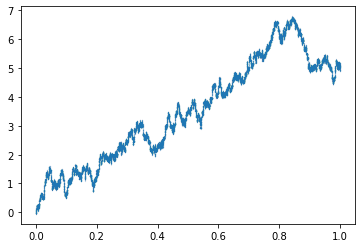

In [89]:
k = 16
sigma = 3
w = wiener(sigma, k)
x = np.linspace(0, 1, 2**k + 1)
plt.plot(x, w, '.', ms = 0.1)

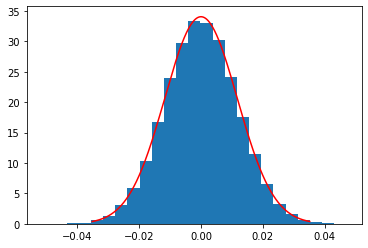

In [90]:
plt.hist(np.diff(w), bins=25, density=True)
h = 1 / 2**k
x = np.linspace(-3 * sigma * np.sqrt(h), 3 * sigma * np.sqrt(h), 2**k)
plt.plot(x, 1 / sigma / np.sqrt(h) * norm.pdf(x / sigma / np.sqrt(h)), c='r')
plt.show()

In [91]:
 def ornstein_uhlenbeck(sigma, lam, k): # моделирует процесс Орнштейна-Уленбека на сетке размера 2^k + 1
    ou = np.zeros(2**k + 1)
    ou[0] = np.random.randn() * sigma
    ou[-1] = sigma * np.sqrt(1 - np.exp(-2 * lam)) * np.random.randn() + ou[0] * np.exp(-lam)
    step = 2**k
    first = 2**(k - 1)
    h = 1
    for i in range(0, k):
        h /= 2
        ou[first::step] = np.random.randn(2**i) * sigma * np.sqrt((np.exp(2 * h * lam) - 1) / (np.exp(2 * h * lam) + 1)) + (ou[:-1:step] + ou[step::step]) / (np.exp(lam * h) + np.exp(-lam * h))
        first = first // 2
        step = step // 2
    return ou

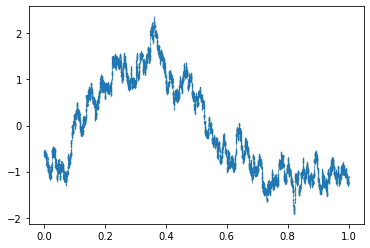

In [92]:
k = 17
sigma = 1
lam = 5
ou = ornstein_uhlenbeck(sigma, lam, k)
x = np.linspace(0, 1, 2**k + 1)
plt.plot(x, ou, '.', ms=0.1)

# Задание 10

#### Произвести фильтрацию одномерного процесса Орнштейна-Уленбека:
#### 1. Используя генератор белого шума, добавить случайную ошибку с известной дисперсией к реализации процесса Орнштейна-Уленбека.
#### 2. При помощи одномерного фильтра Калмана оценить траекторию процесса по зашумленному сигналу. Параметры процесса и белого шума считать известными.
#### 3. Рассмотреть случай, когда шум
   - является гауссовским;
   - имеет распределение Коши.

Рассмотрим сетку $\{t_n = nh, n = 0, 1, \ldots, N\},\ h = \dfrac1N$ и значения процесса Орнштейна-Уленбека
$x_n = X(t_n).$

Представим процесс в виде дискретной динамической системы вида
$$x_{n+1} = ax_n + \nu_n, \quad \mathrm{i.i.d.}\ \nu_n \sim \mathcal{N}(0, q), \quad x_1 \sim \mathcal{N}(0, \sigma^2).$$
Обозначим зашумленный сигнал
$$y_n = x_n + \varepsilon_n, \quad \mathrm{i.i.d.}\ \varepsilon_n \sim \mathcal{N}(0, r).$$
Параметры $\sigma, \lambda$ процесса считаем известными. Найдем через них параметры системы $a, q$. Для этого запишем ковариационную функцию для процесса в моменты $t_n$ и $t_{n+1}$:
$$R(t_n, t_n) = \mathrm{var}(x_n) = \sigma^2,$$
$$R(t_n, t_{n+1}) = \mathrm{cov}(x_n, x_{n+1}) = a\ \mathrm{var}(x_n) = a\sigma^2 = \sigma^2 e^{-\lambda h},$$
$$R(t_{n+1}, t_{n+1}) = \mathrm{var}(x_{n+1}) = a^2\mathrm{var}(x_n) + q = a^2\sigma^2 + q = \sigma^2.$$
Отсюда легко выразить
$$a = e^{-\lambda h}, \quad q = \sigma^2(1 - e^{-2\lambda h}).$$

Опишем один шаг дискретного фильра Калмана. Обозначим за $\hat x_{n|n}$ оценку значения $x_n$ при известных $y_1, \ldots y_n$. $\hat x_{n|n-1}$ - экстраполяция процесса на следующий шаг в соответствии с динамической системой. Через $p_{n|n}$ будем обозначать дисперсию ошибки фильтрации на $n$-м шаге, через $p_{n|n-1}$ - прогнозируемую на следующем шаге дисперсию.

1. Прогнозируем значение процесса и дисперсию ошибки
$$ \hat x_{n|n-1} = a\hat x_{n-1|n-1}, \quad p_{n|n-1} = a^2 p_{n-1|n-1} + q.$$
2. Вычисляем разницу между наблюдаемым процессом и прогнозом и коэффициент усиления Калмана
$$ \delta_{n} = y_n - \hat x_{n|n-1}, \quad k_n = \dfrac{p_{n|n-1}}{p_{n|n-1} + r}.$$
3. В качестве результата фильтрации берем выпуклую комбинацию наблюдаемого и предсказанного значения
$$ \hat x_{n|n} = \hat x_{n|n-1} + k_n\delta_n, \quad p_{k|k} = (1 - k_n)p_{n|n-1}. $$

Поскольку рассматривается линейный фильтр гауссовского процесса с гауссовским шумом, ошибка фильтрации будет иметь нормальное распределение, а доверительный интервал с уровнем доверия $\alpha$ будет иметь вид
$$[\hat x_{n|n} - \Delta, \, \hat x_{n|n} + \Delta], \quad \Delta = -\sqrt{p_{n|n}}\Phi^{-1}\left(\dfrac{\alpha}2\right).$$

#### Нормальная ошибка

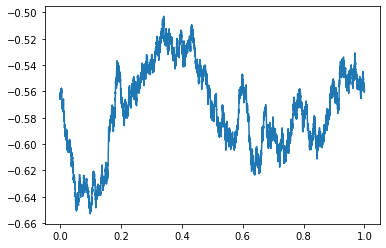

In [121]:
k = 14
n = int(2**k + 1)
sigma = 1
lam = 0.01
x = ornstein_uhlenbeck(sigma, lam, k)
ls = np.linspace(0, 1, n)
plt.plot(ls, x)

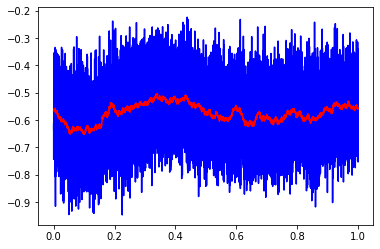

In [249]:
r = 0.01
noise = np.sqrt(r) * np.random.randn(n)
y = x + noise
plt.plot(ls, y, 'b', ls, x, 'r')

In [250]:
def kalman(y, a, q, r):
    n = y.size
    p = np.zeros(n)
    x_est = np.zeros(n)
    x_est[0] = y[0]
    p[0] = r
    for i in range(1, n):
        x_pred = a * x_est[i - 1]
        p_pred = a**2 * p[i - 1] + q
        dif = y[i] - x_pred
        k = p_pred / (p_pred + r)
        x_est[i] = x_pred + k * dif
        p[i] = (1 - k) * p_pred
    return [x_est, p]

In [251]:
h = 1 / (n - 1)
a = np.exp(-lam * h)
q = sigma**2 * (1 - np.exp(-2 * lam * h))

[filtered, err] = kalman(y, a, q, r) 

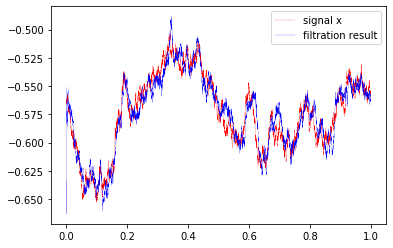

In [252]:
plt.plot(ls, x, 'r--', lw = 0.3, label='signal x')
plt.plot(ls, filtered, 'b', lw=0.2, label='filtration result')
plt.legend()

Out of the confidence interval: 6.225205981080256 %


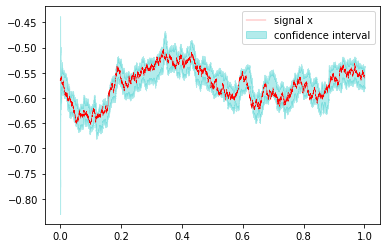

In [257]:
alpha = 0.05
gamma = norm.ppf(alpha / 2)
one_side_error = -np.sqrt(err) * gamma

left = filtered - one_side_error
right = filtered + one_side_error
plt.fill_between(ls, left, right, alpha=0.3, color='c', label='confidence interval')
plt.plot(ls, x, 'r', lw=0.3, label='signal x')
plt.legend()

print('Out of the confidence interval:', ((x < left) + (x > right)).sum() / n * 100, '%')

#### Ошибка имеет распределение Коши

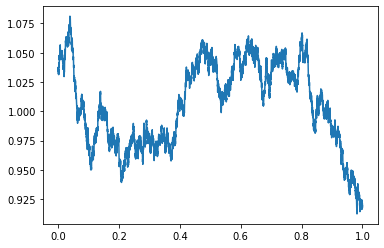

In [258]:
k = 14
n = int(2**k + 1)
sigma = 1
lam = 0.01
x = ornstein_uhlenbeck(sigma, lam, k)
ls = np.linspace(0, 1, n)
plt.plot(ls, x)

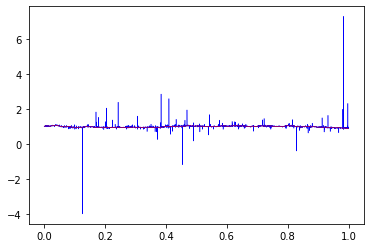

In [307]:
r = 0.001
noise = cauchy_rnd(0, r, n)
y = x + noise
plt.plot(ls, y, 'b', ls, x, 'r', lw=0.5)

In [308]:
h = 1 / (n - 1)
a = np.exp(-lam * h)
q = sigma**2 * (1 - np.exp(-2 * lam * h))

[filtered, err] = kalman(y, a, q, r) 

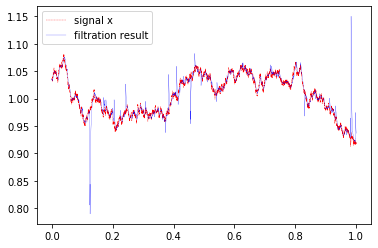

In [309]:
plt.plot(ls, x, 'r--', lw = 0.3, label='signal x')
plt.plot(ls, filtered, 'b', lw=0.2, label='filtration result')
plt.legend()

Out of the confidence interval: 6.402197131522734 %


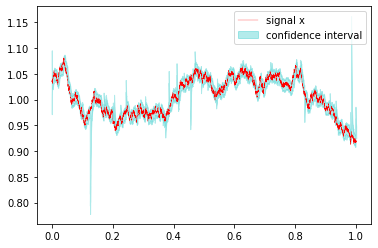

In [310]:
alpha = 0.05
gamma = norm.ppf(alpha / 2)
one_side_error = -np.sqrt(err) * gamma

left = filtered - one_side_error
right = filtered + one_side_error
plt.fill_between(ls, left, right, alpha=0.3, color='c', label='confidence interval')
plt.plot(ls, x, 'r', lw=0.3, label='signal x')
plt.legend()

print('Out of the confidence interval:', ((x < left) + (x > right)).sum() / n * 100, '%')